# V(D)J pseudobulk feature space

In [1]:
import dandelion as ddl
import pandas as pd
import scanpy as sc
import numpy as np
import warnings
import os

warnings.filterwarnings("ignore")

/home/s4778771/miniforge3/envs/dandelion/lib/python3.10/site-packages/nxviz/__init__.py:33: UserWarning: 
nxviz has a new API! Version 0.7.4 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.4, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)



This notebook makes use of Milopy and Palantir, two packages that are not formally Dandelion's dependencies. V(D)J feature space applications are open-ended, this is just one of them. Be sure to install the packages beforehand if you want to follow along.

In [2]:
import pertpy as pt # see issue https://github.com/emdann/milopy/issues/54
import palantir

#required because of Palantir
%matplotlib inline

sc.settings.set_figure_params(dpi=80)

We've prepared a demo object based on the TCR trajectory shown in the manuscript for you to use here. It's had some analysis done on the GEX, and has Dandelion-derived contig information merged into it.

It's possible to use VDJ information that comes from other sources than Dandelion processing, e.g. the pseudobulking will work with Scirpy output. The functions are just calibrated to work with Dandelion's structure by default. **An explicit Scirpy object example will be shown later.**

In [3]:
if not os.path.exists("demo-pseudobulk.h5ad"):
    os.system("wget ftp://ftp.sanger.ac.uk/pub/users/kp9/demo-pseudobulk.h5ad")

The full data used in the Nature Biotechnology paper is available at a separate [repository](https://github.com/zktuong/dandelion-demo-files/tree/master/dandelion_manuscript).

Prior to performing the pseudobulking, it is recommended to run `ddl.tl.setup_vdj_pseudobulk()`. This will subset the object to just cells with at least a pair of chains, and prepare appropriately named and formatted columns for the pseudobulking function to use as defaults.

In [4]:
adata = sc.read("demo-pseudobulk.h5ad")
adata = ddl.tl.setup_vdj_pseudobulk(adata)

We're going to be using Milopy to create pseudobulks. Construct a neighbour graph with many neighbours, following Milopy protocol, and then sample representative neighbourhoods from the object. This saves a cell-by-pseudobulk matrix into `adata.obsm["nhoods"]`. Use this graph to generate a UMAP as well.

In [5]:
sc.pp.neighbors(adata, use_rep="X_scvi", n_neighbors=50)
milo = pt.tl.Milo()
milo.make_nhoods(adata)
sc.tl.umap(adata)

Now we are armed with everything we need to construct the VJ feature space. Pseudobulks can be defined either via passing a list of `.obs` metadata columns, the unique values of the combination of which will serve as individual pseudobulks (via `obs_to_bulk`), or via an explicit cell-by-pseudobulk matrix (via `pbs`). Milopy created one of those for us, so we can use that as input.

The cell type annotation lives in `.obs["anno_lvl_2_final_clean"]`. Let's tell the function that we want to take the most common value per pseudobulk with us to the new VJ feature space object.

In [6]:
pb_adata = ddl.tl.vdj_pseudobulk(
    adata, pbs=adata.obsm["nhoods"], obs_to_take="anno_lvl_2_final_clean"
)

The new object has pseudobulks as observations, and the unique encountered VJ genes as the features. We can see the per-pseudobulk annotation, and `.obsm["pbs"]`. In our case it's just a copy of the `pbs` argument, but if we were to go for `obs_to_bulk` this would be a cells by pseudobulks matrix capturing the assignment of the original cells.

In [7]:
pb_adata

AnnData object with n_obs × n_vars = 1341 × 160
    obs: 'anno_lvl_2_final_clean', 'anno_lvl_2_final_clean_fraction', 'cell_count'
    obsm: 'pbs'

Now that we have our VJ feature space pseudobulk object, we can do things with it. Let's run a PCA on it. The development trajectory is very nicely captured in the first two PC dimensions.

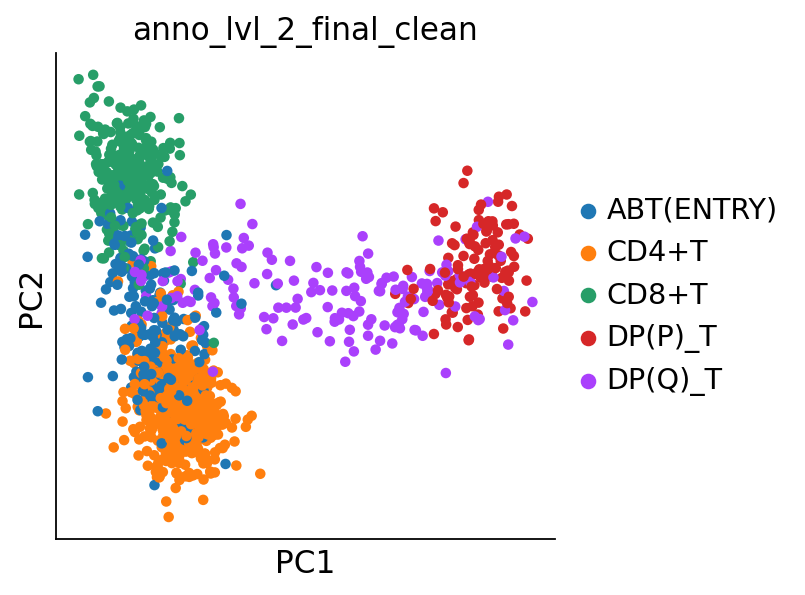

In [9]:
sc.tl.pca(pb_adata)
sc.pl.pca(pb_adata, color="anno_lvl_2_final_clean")

Let's define the start of our trajectory as the right-most cell, the CD4 terminal state as the bottom-most cell, and the CD8 terminal state as the top-most cell. We can then follow Palantir protocol to generate a diffusion map and run pseudotime. Once done, we rename the terminal states to be more informative.

In [9]:
rootcell = np.argmax(pb_adata.obsm["X_pca"][:, 0])
terminal_states = pd.Series(
    ["CD8+T", "CD4+T"],
    index=pb_adata.obs_names[
        [
            np.argmax(pb_adata.obsm["X_pca"][:, 1]),
            np.argmin(pb_adata.obsm["X_pca"][:, 1]),
        ]
    ],
)

# Run diffusion maps
pca_projections = pd.DataFrame(pb_adata.obsm["X_pca"], index=pb_adata.obs_names)
dm_res = palantir.utils.run_diffusion_maps(pca_projections, n_components=5)
ms_data = palantir.utils.determine_multiscale_space(dm_res)

pr_res = palantir.core.run_palantir(
    ms_data,
    pb_adata.obs_names[rootcell],
    num_waypoints=500,
    terminal_states=terminal_states.index,
)

pr_res.branch_probs.columns = terminal_states[pr_res.branch_probs.columns]

Determing nearest neighbor graph...
Sampling and flocking waypoints...
Time for determining waypoints: 0.0026925047238667804 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...


findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back t

Time for shortest paths: 0.054726286729176836 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


We can easily transfer the inferred pseudotime and branching probabilities to the pseudobulk object with the aid of a helper function.

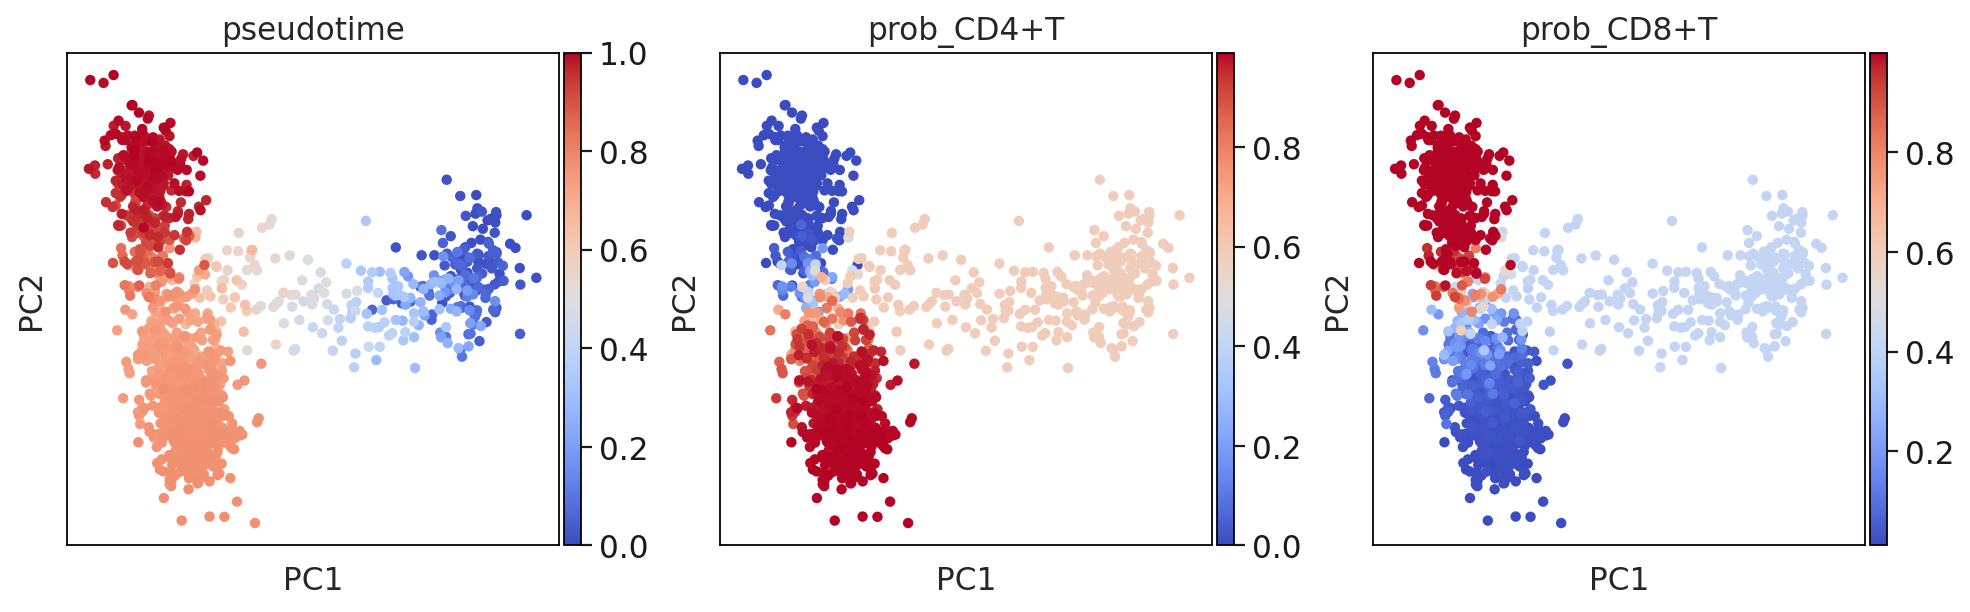

In [10]:
pb_adata = ddl.tl.pseudotime_transfer(pb_adata, pr_res)
sc.pl.pca(
    pb_adata,
    color=["pseudotime", "prob_CD4+T", "prob_CD8+T"],
    color_map="coolwarm",
)

We can project back our findings to the original cell space object via another helper function. This will remove any cells not in any of the pseudobulks. In the event of a cell belonging to multiple pseudobulks, the cell's pseudotime will be the average of the pseudobulks weighted by the inverse of the pseudobulk size.

number of cells removed due to not belonging to any neighbourhood 87


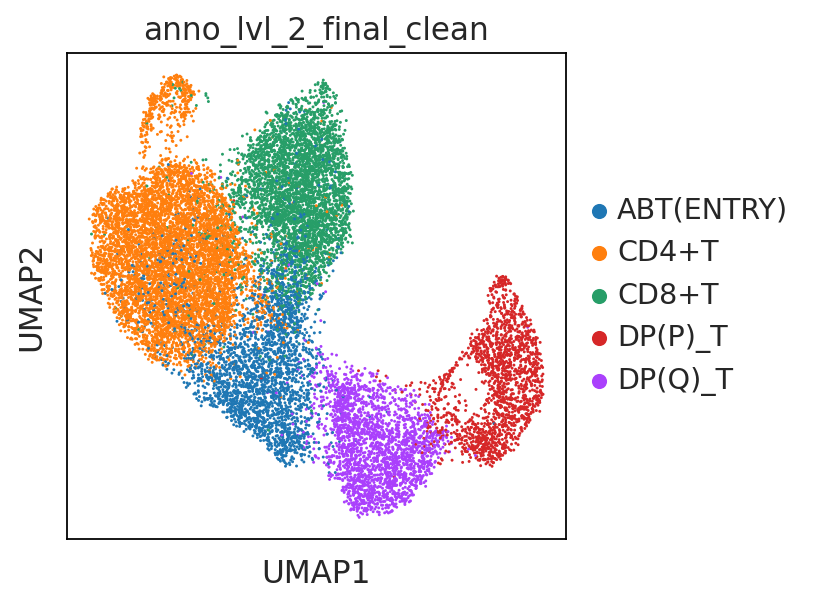

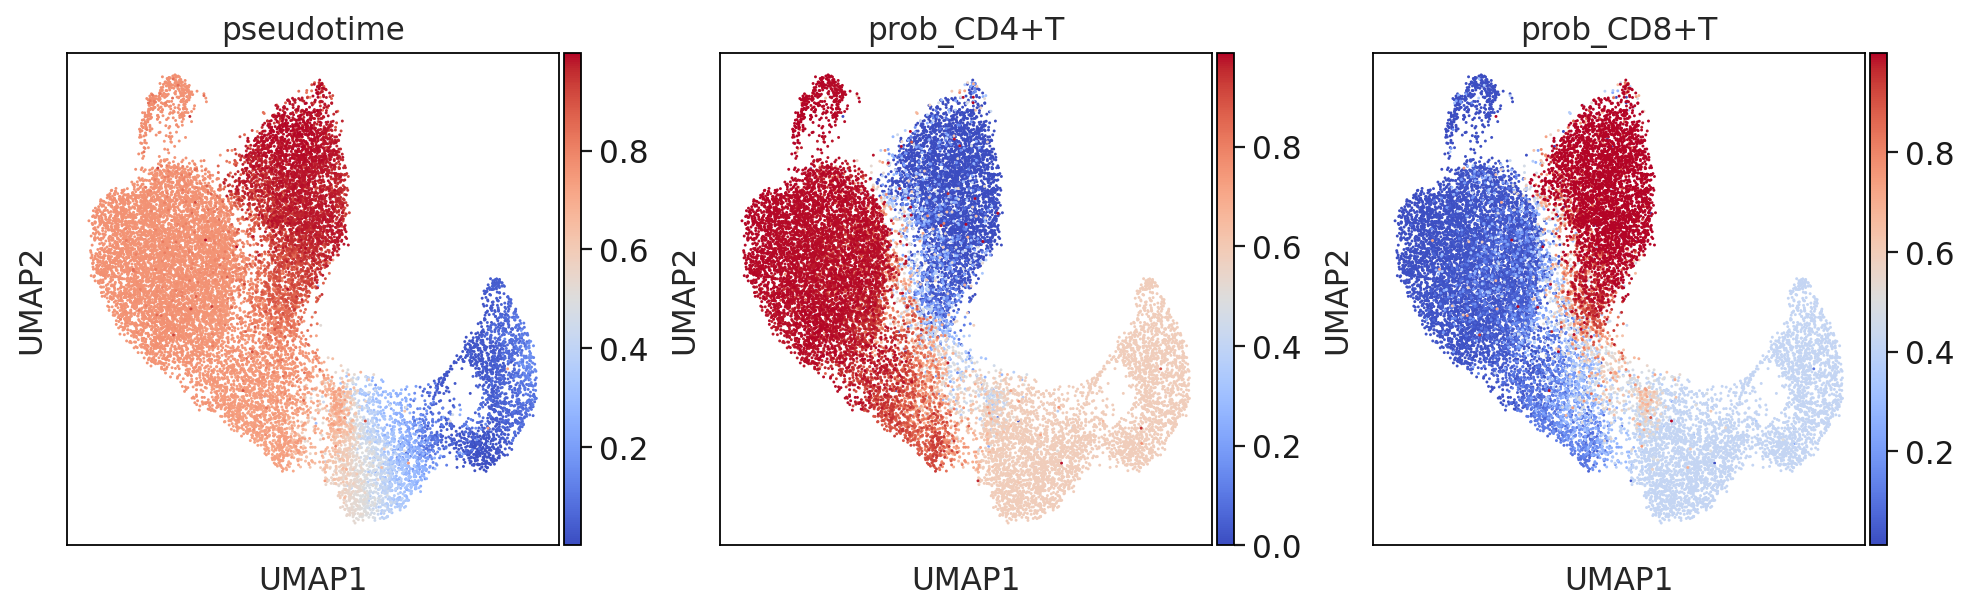

In [11]:
bdata = ddl.tl.project_pseudotime_to_cell(
    adata, pb_adata, terminal_states.values
)
sc.pl.umap(bdata, color=["anno_lvl_2_final_clean"])
sc.pl.umap(
    bdata,
    color=["pseudotime", "prob_CD4+T", "prob_CD8+T"],
    color_map="coolwarm",
)

## Pseudobulking on a Scirpy object

It's possible to use the pseudobulking functions on a Scirpy object directly, but it will require some different arguments and minimal manual preprocessing beforehand. Let's grab a Scirpy object, availabe [here](https://cellgeni.cog.sanger.ac.uk/pan-immune/adata_TILC_TCR_onlyseq.h5ad), and see how we would go about this.

In [12]:
if not os.path.exists("adata_TILC_TCR_onlyseq.h5ad"):
    os.system(
        "wget https://cellgeni.cog.sanger.ac.uk/pan-immune/adata_TILC_TCR_onlyseq.h5ad"
    )

Load the object and simplify its annotation.

In [13]:
adata = sc.read("adata_TILC_TCR_onlyseq.h5ad")

# retain the following clusters
ct_order = [
    "MAIT",
    "Tem/emra_CD8",
    "Tnaive/CM_CD8",
    "Trm/em_CD8",
    "Trm_gut_CD8",
    "Teffector/EM_CD4",
    "Tfh",
    "Tnaive/CM_CD4",
    "Tnaive/CM_CD4_activated",
    "Tregs",
    "Trm_Th1/Th17",
]
adata = adata[adata.obs["manual_annot_v6"].isin(ct_order)]

# simplify the annotation to CD4, CD8 and MAIT
translate = {"MAIT": "MAIT"}
for clus in ["Tem/emra_CD8", "Tnaive/CM_CD8", "Trm/em_CD8", "Trm_gut_CD8"]:
    translate[clus] = "CD8+T"
for clus in [
    "Teffector/EM_CD4",
    "Tfh",
    "Tnaive/CM_CD4",
    "Tnaive/CM_CD4_activated",
    "Tregs",
    "Trm_Th1/Th17",
]:
    translate[clus] = "CD4+T"
adata.obs["annot_high"] = (
    adata.obs["manual_annot_v6"].astype("str").map(translate)
)

`ddl.tl.setup_vdj_pseudobulk()` subsets the object to cells with both chains present. We'll have to do this manually.

In [14]:
adata = adata[
    adata.obs["chain_pairing"].isin(
        ["single pair", "extra VJ", "extra VDJ", "two full chains"]
    )
]

At this point, the Scirpy object can be fed into `ddl.tl.vdj_pseudobulk()`. The columns with the VDJ calls are named differently than in the Dandelion object, but this can be accounted for by specifying `extract_cols = ['IR_VDJ_1_v_gene', 'IR_VDJ_1_j_gene', 'IR_VJ_1_v_gene', 'IR_VJ_1_j_gene']`.

For illustrative purposes, let's perform pseudobulking based on cell metadata rather than neighbourhoods - a combination of the original granular annotation and donor ID, present as columns in `.obs`. This would work just fine with a matrix of pseudobulk assignments like was done earlier with Milo for the Dandelion example.

In [15]:
pb_adata = ddl.tl.vdj_pseudobulk(
    adata,
    obs_to_bulk=["donor_id", "manual_annot_v6"],
    obs_to_take=["donor_id", "manual_annot_v6", "annot_high"],
    extract_cols=[
        "IR_VDJ_1_v_gene",
        "IR_VDJ_1_j_gene",
        "IR_VJ_1_v_gene",
        "IR_VJ_1_j_gene",
    ],
)

Let's make a UMAP of the pseudobulks. The object is operational.

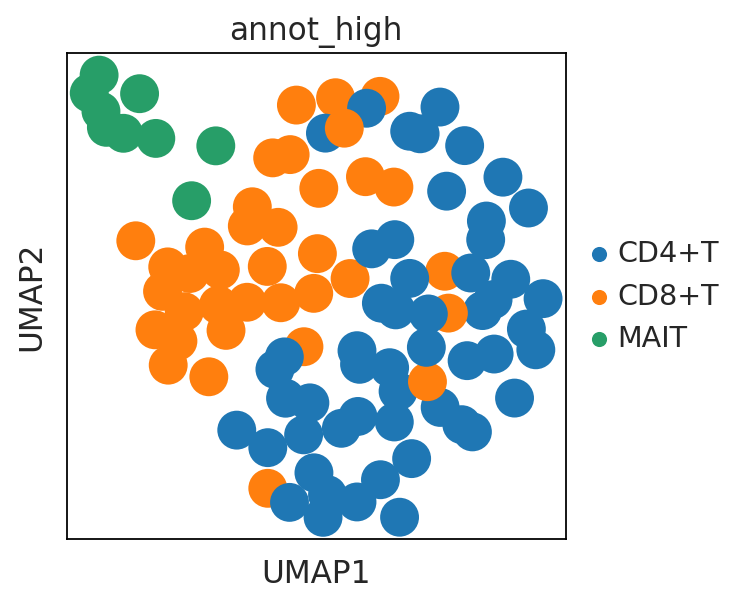

In [ ]:
sc.tl.pca(pb_adata)
sc.pp.neighbors(pb_adata)
sc.tl.umap(pb_adata)
sc.pl.umap(pb_adata, color="annot_high")